In [1]:
import os

from keras_preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-inception-v2-reduced-rgb"


/home/jelinek/recetox/src/notebooks/MyCNNInception


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1,1), pool_size=(3,3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3,3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5,5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(p1)

        output_layer = concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(inputs,
                                                filters_1=4,
                                                filters_2=4)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=8,
                                                filters_2=8)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=16,
                                                filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=32,
                                                filters_2=32)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=64,
                                                filters_2=64)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=128,
                                                filters_2=128)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

2022-02-23 13:33:40.969801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 13:33:40.970000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-23 13:33:40.970044: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-23 13:33:40.973685: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-23 13:33:40.973794: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-23 13:33:40.999158: I tensorflow/stream_exec

Model: "MySimpleCnnFewerLayers"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
_____________________________________________________________________________

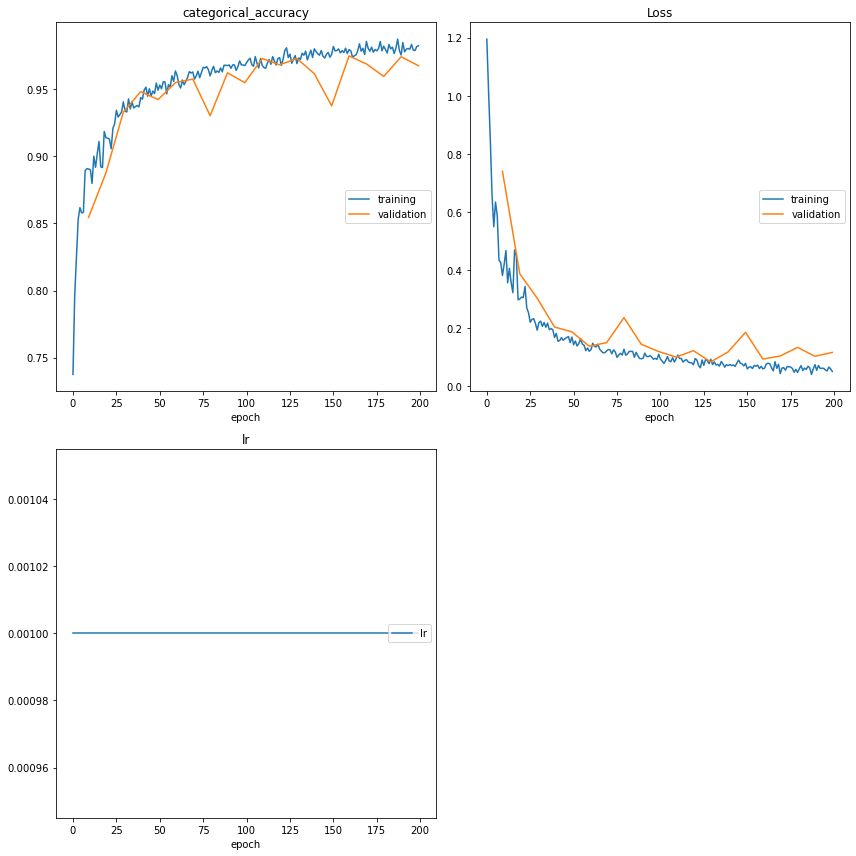

categorical_accuracy
	training         	 (min:    0.738, max:    0.987, cur:    0.982)
	validation       	 (min:    0.854, max:    0.975, cur:    0.967)
Loss
	training         	 (min:    0.040, max:    1.195, cur:    0.050)
	validation       	 (min:    0.083, max:    0.740, cur:    0.116)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
95/95 [==============================] - 5s 49ms/step - loss: 0.1159 - categorical_accuracy: 0.9674
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4868ms
Confusion Matrix
[[330   0   0   0   2   0   0   0   0   0   2   1]
 [  5  51   5   0   2   0   1   0   0   0   0   0]
 [  2   1 141   0   1   0   0   0   0   0   0   0]
 [  0   0   0   9   1   0   1   0   0   0   0   0]
 [  1   0   0   1 542   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  1   6   1   0   0   0  69   0   0   0   0   0]
 [  1   1   2   0   0   0   1  81   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           pipeline_name=name,
           save_misclassified=True)

Found 1505 images belonging to 12 classes.
95/95 [==============================] - 5s 50ms/step - loss: 0.1159 - categorical_accuracy: 0.9674
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4182ms
Confusion Matrix
[[330   0   0   0   2   0   0   0   0   0   2   1]
 [  5  51   5   0   2   0   1   0   0   0   0   0]
 [  2   1 141   0   1   0   0   0   0   0   0   0]
 [  0   0   0   9   1   0   1   0   0   0   0   0]
 [  1   0   0   1 542   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  1   6   1   0   0   0  69   0   0   0   0   0]
 [  1   1   2   0   0   0   1  81   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0]
 [  9   0   0   0   0   0   0   0   0   0 225   0]
 [  0   0   0   0   0   0   0   0   0   0   0   6]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.95      0.99      0.96 

In [3]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [4]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 1 out of 120

ValueError: could not broadcast input array from shape (12) into shape (11)